In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/critical-heat-flux-dataset/Data_CHF_Zhao_2020_ATE.csv


## Importing the required library

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Dropout

import warnings
warnings.filterwarnings('ignore')

In [39]:
df = pd.read_csv("/kaggle/input/critical-heat-flux-dataset/Data_CHF_Zhao_2020_ATE.csv")

In [40]:
df.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [41]:
df = df.drop("id", axis=1)

In [42]:
# Change the name of the columns
new_column_names = ['author', 'geometry', 'pressure', 'mass_flux', 'exit_concentration', 'equivalent_diameter', 'hydraulic_diameter', 'channel_length', 'exp_critical_heat_flux']

# Replace the column names wrt to df
df.columns = new_column_names

In [43]:
df.head()

,author,geometry,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length,exp_critical_heat_flux
0,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


## Exploratory Data Analysis

In [44]:
df.shape

(1865, 9)

In [45]:
df.describe()

,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length,exp_critical_heat_flux
count,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000
mean,10.010949,2862.647721,0.016179,9.417212,16.167721,911.340483,3.854638
std,4.282715,1656.412247,0.117575,6.333807,21.182870,726.718974,1.985535
min,0.100000,0.000000,-0.866700,1.000000,1.000000,10.000000,0.800000
25%,6.890000,1519.000000,-0.048300,5.600000,5.600000,432.000000,2.400000
50%,10.340000,2590.000000,0.024400,8.500000,10.300000,625.000000,3.500000
75%,13.790000,3933.000000,0.100600,11.100000,15.200000,1778.000000,4.800000
max,20.680000,7975.000000,0.232000,37.500000,120.000000,3048.000000,19.300000


In [46]:
df.isna().sum()

author                    0
geometry                  0
pressure                  0
mass_flux                 0
exit_concentration        0
equivalent_diameter       0
hydraulic_diameter        0
channel_length            0
exp_critical_heat_flux    0
dtype: int64

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
    
* Dataset haven't any null values

In [47]:
grouped_df = df.groupby(['author', 'geometry']).size().reset_index(name = "Count")
grouped_df

,author,geometry,Count
0,Beus,annulus,77
1,Inasaka,tube,7
2,Janssen,annulus,282
3,Kossolapov,plate,12
4,Mortimore,annulus,19
5,Peskov,tube,17
6,Richenderfer,plate,36
7,Thompson,tube,1202
8,Weatherhead,tube,162
9,Williams,tube,51


In [48]:
ctg = pd.crosstab(df['author'],df['geometry'])
ctg

geometry,annulus,plate,tube
author,,,
Beus,77,0,0
Inasaka,0,0,7
Janssen,282,0,0
Kossolapov,0,12,0
Mortimore,19,0,0
Peskov,0,0,17
Richenderfer,0,36,0
Thompson,0,0,1202
Weatherhead,0,0,162


In [49]:
df['author'].unique()

array(['Inasaka', 'Peskov', 'Thompson', 'Weatherhead', 'Williams', 'Beus',
       'Janssen', 'Mortimore', 'Kossolapov', 'Richenderfer'], dtype=object)

In [50]:
df['geometry'].unique()

array(['tube', 'annulus', 'plate'], dtype=object)

In [51]:
df.head()

,author,geometry,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length,exp_critical_heat_flux
0,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


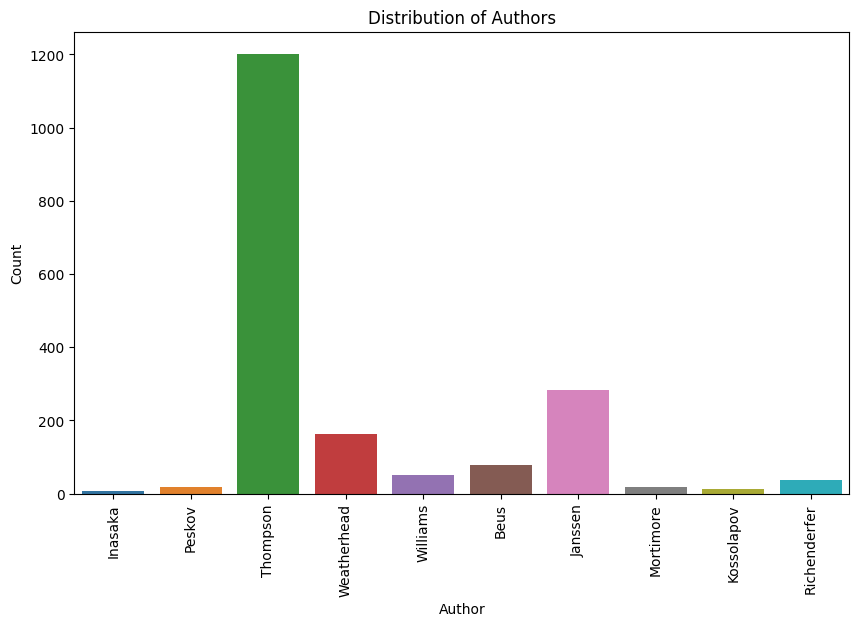

In [52]:
# Plot the count plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df[['author', 'geometry']], x="author")
sns.countplot(data=df[['author', 'geometry']], x="author")
plt.title("Distribution of Authors")
plt.xlabel("Author")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

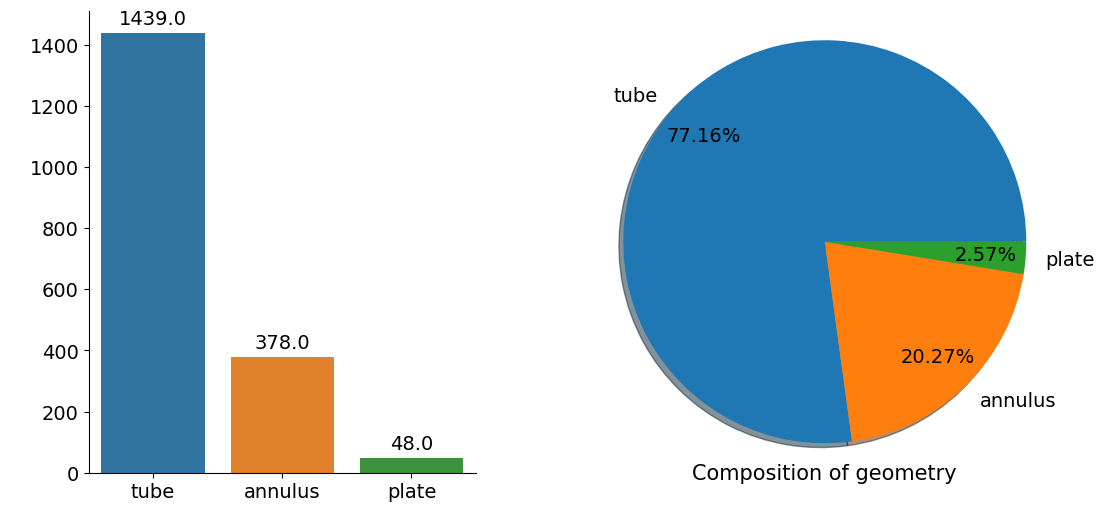

In [53]:
def plot_count(df):
    # checking the target
    plt.figure(figsize=(12, 6))
    
    # Barplot
    ax1 = plt.subplot(1, 2, 1)
    cp = sns.countplot(x=df["geometry"])

    # Add count numbers on top of the bars
    for p in ax1.patches:
        ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=14)

    ax1.set_xlabel(" ")
    ax1.set_ylabel(" ")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    sns.despine(top=True, right=True)

    # Pieplot
    ax2 = plt.subplot(1, 2, 2)
    
    # Ensure that the length of explode matches the number of unique categories
    explode = [0.3, 0]  # Adjust this list based on your data
    
    plt.pie(df["geometry"].value_counts(),
            labels=list(df["geometry"].unique()),
            autopct='%1.2f%%',
            pctdistance=0.8,
            shadow=True,
            radius=1.3,
            textprops={'fontsize': 14}
            )
    ax2.set_xlabel(" ")
    plt.xlabel('Composition of geometry', fontsize=15, labelpad=20)
    plt.subplots_adjust(wspace=0.4)
    plt.show()

# Assuming df is your DataFrame
plot_count(df)


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
    
* Approx 77% geometry tube has been utilized

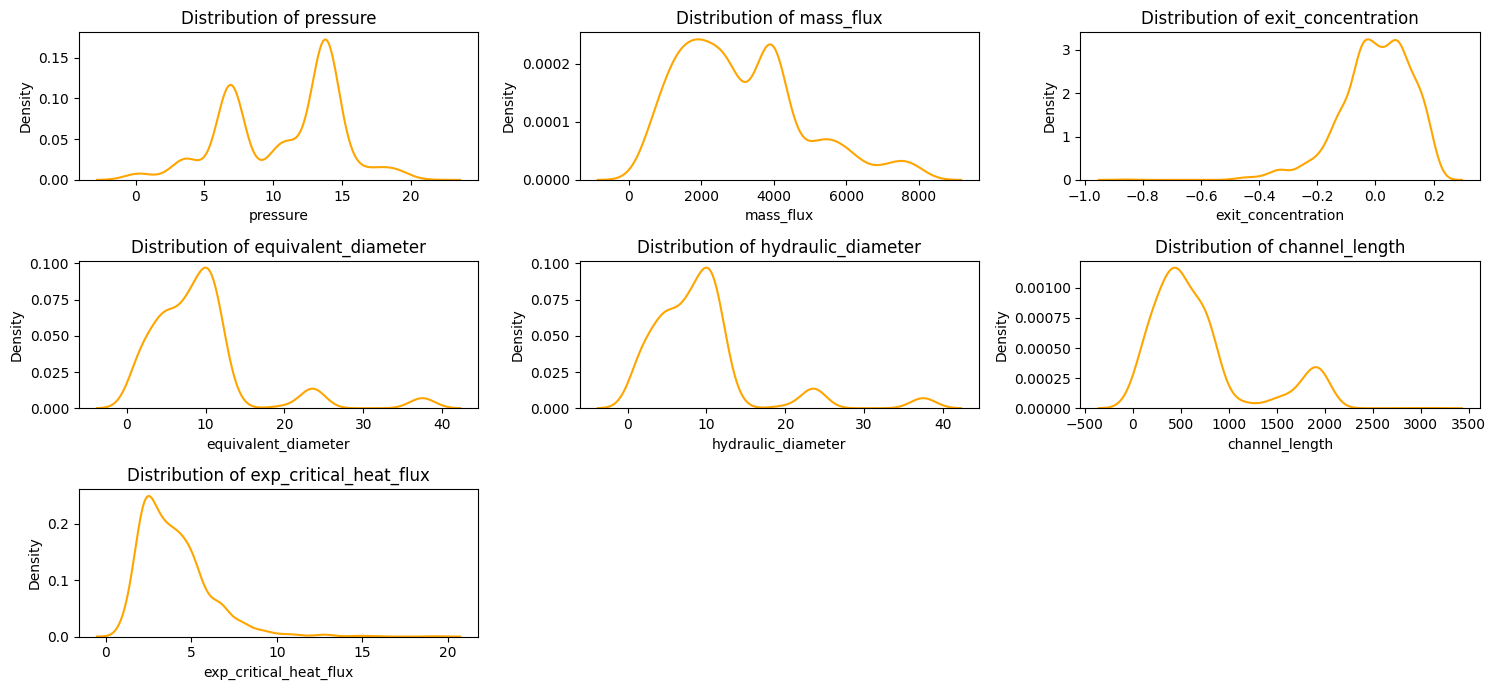

In [54]:
# create sepearte df for each unique geometry for analysis
Tube = df[df['geometry']=='tube']
# check the distribution of the dataset withrespect to each geometry

plt.figure(figsize=(15, 7))
for i, feature in enumerate(Tube.iloc[:,2:]):
    plt.subplot(3, 3, i + 1)
    sns.distplot(Tube[feature], color='orange', hist=False, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

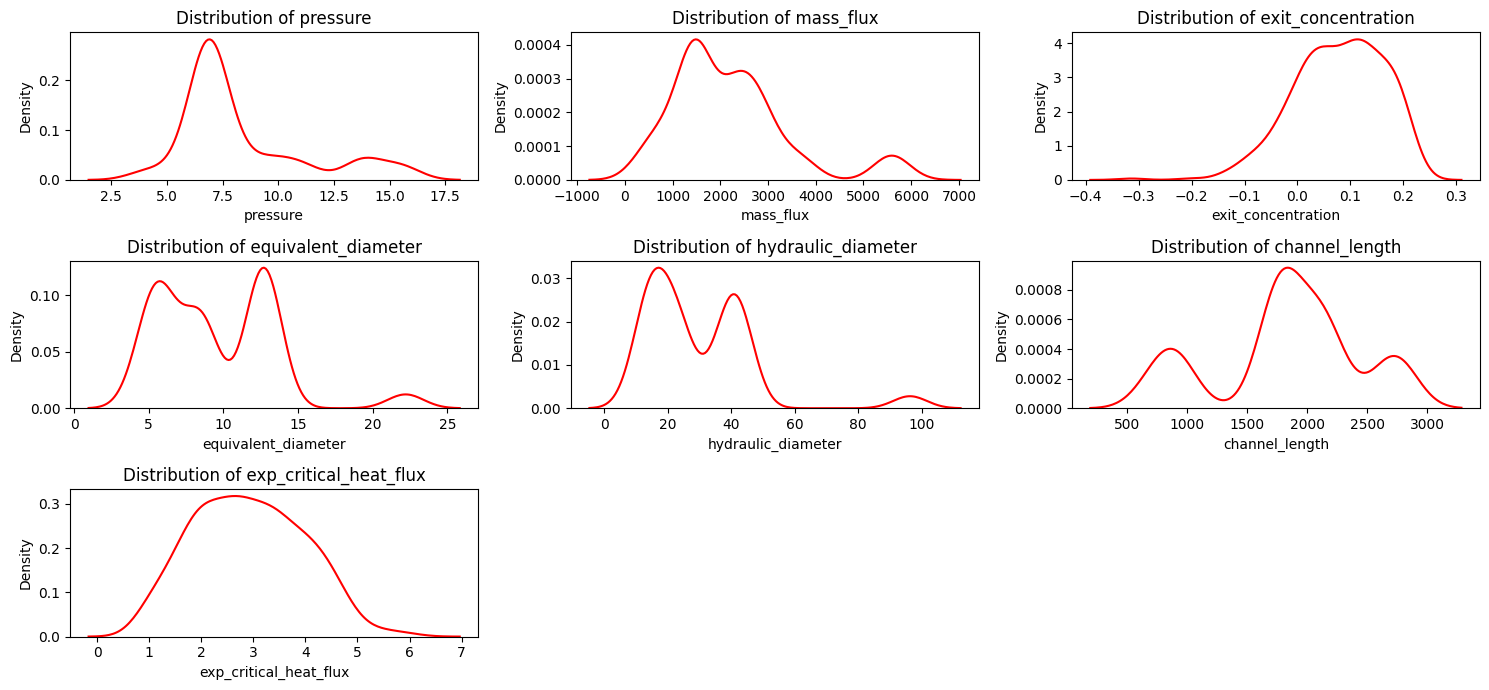

In [55]:
# create sepearte df for each unique geometry for analysis
Tube = df[df['geometry']=='annulus']
# check the distribution of the dataset withrespect to each geometry

plt.figure(figsize=(15, 7))
for i, feature in enumerate(Tube.iloc[:,2:]):
    plt.subplot(3, 3, i + 1)
    sns.distplot(Tube[feature], color='red', hist=False, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

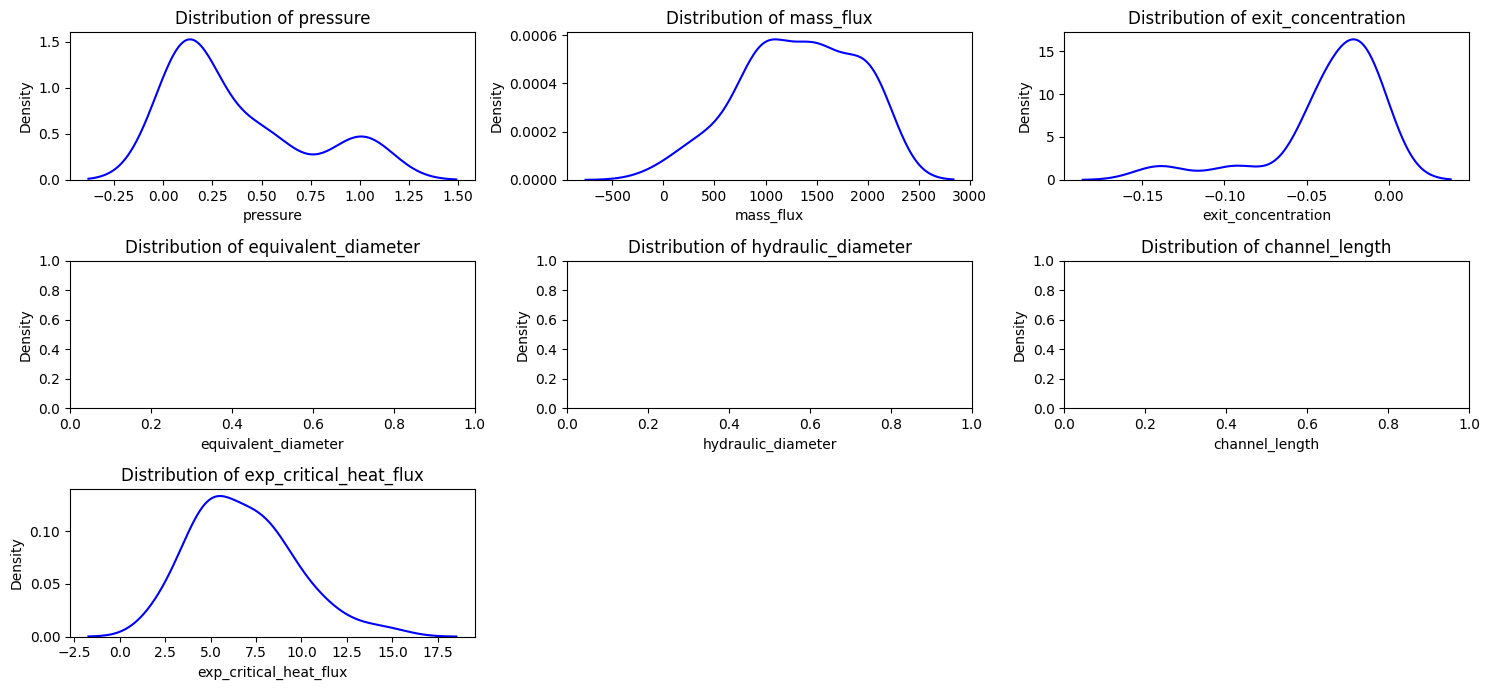

In [56]:
# create sepearte df for each unique geometry for analysis
Tube = df[df['geometry']=='plate']
# check the distribution of the dataset withrespect to each geometry

plt.figure(figsize=(15, 7))
for i, feature in enumerate(Tube.iloc[:,2:]):
    plt.subplot(3, 3, i + 1)
    sns.distplot(Tube[feature], color='blue', hist=False, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [57]:
# Encoding the author and geometry feature values
label_encoder = LabelEncoder()
df['author'] = label_encoder.fit_transform(df['author'])
df['geometry'] = label_encoder.fit_transform(df['geometry'])

In [58]:
print(df['author'].unique())
print(df['geometry'].unique())

[1 5 7 8 9 0 2 4 3 6]
[2 0 1]


<Axes: >

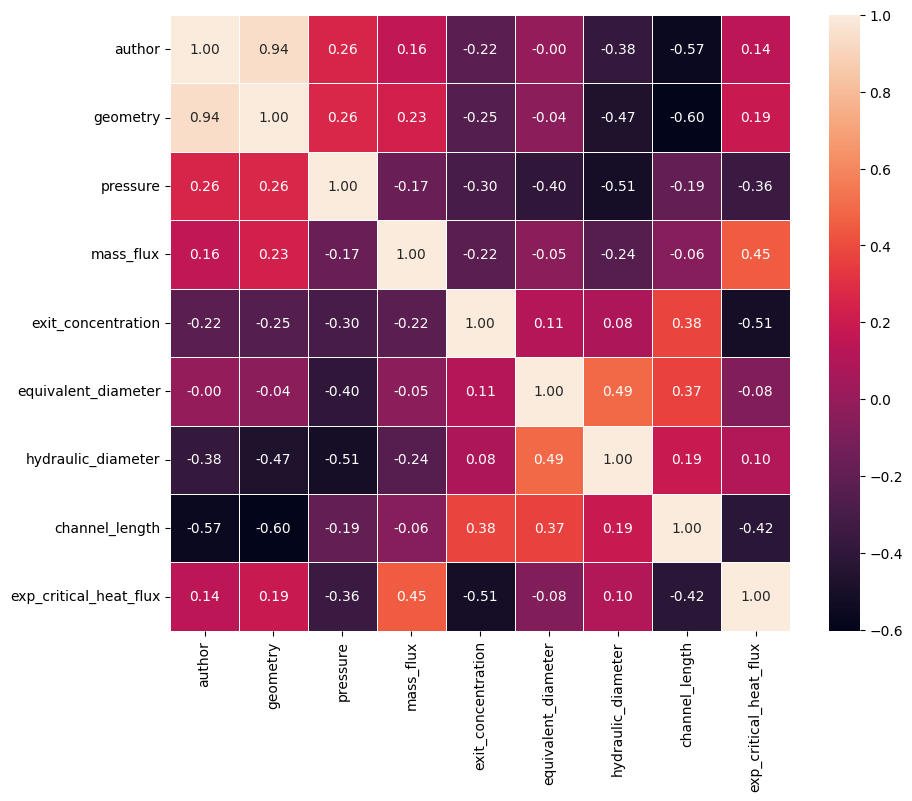

In [59]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=.5)

In [60]:
# Split the data into features and target variable
X = df.drop('exp_critical_heat_flux', axis=1)
y = df['exp_critical_heat_flux']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [62]:
print(f'Trainning data size of X: {X_train.shape} y:, {y_train.shape}')
print(f'test data size of X: {X_test.shape} y:, {y_test.shape}')

Trainning data size of X: (1492, 8) y:, (1492,)
test data size of X: (373, 8) y:, (373,)


## Model evaluation

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation ='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                576       
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

In [66]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate the mean squared error and r2 score
mse = mean_squared_error(y_test, y_pred)

# Calculate the metrics
r2 = r2_score(y_test, y_pred)
print('R2 Score:', r2)
print("Mean Square Error:",mse)
print("Root Mean Square Error:",np.sqrt(mse))

12/12 [==============================] - 0s 2ms/step
R2 Score: 0.857609199943834
Mean Square Error: 0.7262873190495313
Root Mean Square Error: 0.8522249228047319


In [67]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation ='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                576       
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (

In [68]:
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
47/47 - 1s - loss: 11.8025 - 967ms/epoch - 21ms/step
Epoch 2/50
47/47 - 0s - loss: 3.2813 - 78ms/epoch - 2ms/step
Epoch 3/50
47/47 - 0s - loss: 2.3187 - 87ms/epoch - 2ms/step
Epoch 4/50
47/47 - 0s - loss: 2.0381 - 89ms/epoch - 2ms/step
Epoch 5/50
47/47 - 0s - loss: 1.9058 - 87ms/epoch - 2ms/step
Epoch 6/50
47/47 - 0s - loss: 1.8022 - 84ms/epoch - 2ms/step
Epoch 7/50
47/47 - 0s - loss: 1.8256 - 87ms/epoch - 2ms/step
Epoch 8/50
47/47 - 0s - loss: 1.5535 - 81ms/epoch - 2ms/step
Epoch 9/50
47/47 - 0s - loss: 1.6044 - 84ms/epoch - 2ms/step
Epoch 10/50
47/47 - 0s - loss: 1.5945 - 97ms/epoch - 2ms/step
Epoch 11/50
47/47 - 0s - loss: 1.4400 - 88ms/epoch - 2ms/step
Epoch 12/50
47/47 - 0s - loss: 1.3251 - 94ms/epoch - 2ms/step
Epoch 13/50
47/47 - 0s - loss: 1.5413 - 127ms/epoch - 3ms/step
Epoch 14/50
47/47 - 0s - loss: 1.4481 - 89ms/epoch - 2ms/step
Epoch 15/50
47/47 - 0s - loss: 1.3426 - 94ms/epoch - 2ms/step
Epoch 16/50
47/47 - 0s - loss: 1.4869 - 88ms/epoch - 2ms/step
Epoch 17/50
4

In [69]:
y_pred = model.predict(X_test_scaled)

# Calculate the mean squared error and r2 score
mse = mean_squared_error(y_test, y_pred)

# Calculate the metrics
r2 = r2_score(y_test, y_pred)
print('R2 Score:', r2)
print("Mean Square Error:",mse)
print("Root Mean Square Error:",np.sqrt(mse))

12/12 [==============================] - 0s 2ms/step
R2 Score: 0.824777546553782
Mean Square Error: 0.8937504803718818
Root Mean Square Error: 0.9453837741213257


In [72]:
import joblib 
joblib.dump(model, "CHF_model.joblib")
joblib.dump(label_encoder, "label_encoder.joblib")

['label_encoder.joblib']